In [11]:
import time
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import helpers as helpers
from scipy.optimize import minimize, show_options, basinhopping, differential_evolution, brute

#### Empecemos por cargar los datos

In [2]:
path = "../data/data.xlsx"

In [3]:
df = helpers.dataframe(path)

In [4]:
df

,10Y,7Y,5Y,3Y,2Y,1Y,6M,3M
Date,,,,,,,,
2022-02-16,2.044,2.025,1.921,1.762,1.530,1.043,0.699,0.402
2022-02-11,1.941,1.940,1.856,1.728,1.505,1.029,0.692,0.359
2022-02-04,1.911,1.884,1.770,1.536,1.313,0.869,0.550,0.230
2022-01-28,1.772,1.739,1.613,1.375,1.164,0.744,0.424,0.185
2022-01-21,1.760,1.713,1.559,1.287,1.005,0.555,0.354,0.167
...,...,...,...,...,...,...,...,...
2018-03-16,2.845,2.778,2.643,2.444,2.293,2.054,1.945,1.773
2018-03-09,2.895,2.811,2.651,2.432,2.260,2.023,1.874,1.664
2018-03-02,2.865,2.788,2.629,2.397,2.243,2.044,1.841,1.644


In [5]:
firstyields = df[df.index == "2022-02-11"]

In [6]:
today = firstyields.index

In [7]:
today

DatetimeIndex(['2022-02-11'], dtype='datetime64[ns]', name='Date', freq=None)

#### Partimos de un vector de alphas (nuestra curva), creada al azar

In [8]:
alphas = (0.1,0.11,0.12,0.13,0.14)

#### Suponemos que: 
- $\alpha_1$ representa la tasa forward entre 0 y 3 meses, 
- $\alpha_2$ la tasa entre 3 meses y 1 año, 
- $\alpha_3$ la tasa entre 1 y 3 años,
- $\alpha_4$ la tasa entre 3 y 5 años ,
- $\alpha_5$ la tasa entre 5 y 10 años.

#### Ahora bien, para valorar un bono, se sigue que:

$$ \sum_{i=1}^{T} \frac{(C \% *100)}{{(1+y_i)}^{t_i}} + \frac {N}{{(1+y_i)}^{T}}$$ 

#### Además, para traer a valor presente usando una curva forward, se sigue el factor de descuento a un plazo T es: 

### $$ e^{-\int_{0}^{T} f(t) \,dt}$$

#### Con lo anterior, para valorar un bono para el taller, se sigue que:
$$ \sum_{i=1}^{T} (C \% *100)*e^{-\int_{0}^{T} f(t) \,dt} +  {N}*{e^{-\int_{0}^{T} f(t) \,dt}}$$ 

#### Así, para convertir las tasas anualizadas utilzaremos la siguiente función:

In [9]:
def rateconverter(rate, T, today):
    """
    Returns a converted interest rate, for a desired maturity.
    Parameters:
        rate: yearly interest rate
        T: maturity in months
        today: current date, expressed as a DateTimeIndex
    """
    days = (today[0].date()+relativedelta(months=T) - today[0].date()).days
    semrate = ((1+rate)**(1/2)-1)
    newrate = semrate*days/360
    return round(newrate,decimals = 5)

#### Y para hallar los factores de descuento, asumiendo una curva constante a trozos:

In [10]:
def discountfactor(curve, T):
    """
    Returns the discount factor for a given maturity and forward curve, assuming a constant stepwise curve 
    Parameters:
        curve: forward curve
        T: maturity in months
    """
    intervals_r=[3,12,36,60,120]
    intervals_l=[0,3,12,36,60]
    mask = [(t<=T) for t in intervals_l]
    minimum = np.minimum(T, intervals_r)
    areas = ((minimum-intervals_l)/12)*curve*mask
    totalarea = np.sum(areas)
    print(totalarea)
    discountfactor = np.exp(-totalarea)
    return discountfactor

In [9]:
helpers.discountfactor(alphas, 6)

0.9488543210558013

In [12]:
tmb = 100 +helpers.threemonthrateconverter(firstyields["3M"][0], 3 , today)*helpers.discountfactor(alphas, 6)
tmb

100.01869688458873

#### Miremos cómo se comporta la función para el factor de descuento:

In [13]:
alphas = np.arange (0.1,0.6,.01)
maturities = np.arange(1,51,1)
discounts = list(map(helpers.discountfactor, alphas, maturities))

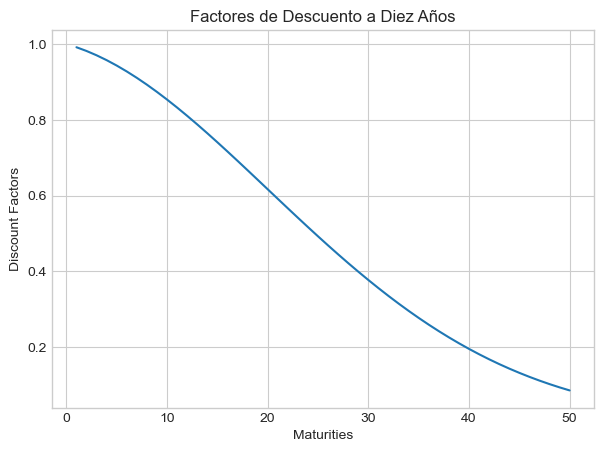

In [14]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.xlabel('Maturities')
plt.ylabel('Discount Factors')
plt.title('Factores de Descuento a Diez Años')
plt.plot(maturities,discounts)

#### Ahora definamos la función de pagos para un bono específico:

In [15]:
alphas2 = [0.07853351, 0.08539753, 0.04942368, 0.08465615, 0.0079]

In [16]:
def singlebondpayment(T, rate, alpha, today, threemonth = False):
    if threemonth == True:
        return helpers.threemonthrateconverter(rate, T, today)*helpers.discountfactor(alpha, T)
    return helpers.rateconverter(rate, T, today)*helpers.discountfactor(alpha, T)

#### Generalizando para cualquier bono:

In [19]:
def bondvalue(today, T, rates, alpha):
    if T == 3:
        return singlebondpayment(3, rates["3M"][0], alpha, today, threemonth= True) + 100*helpers.discountfactor(alpha , T)
    else:
        maturitynames = [i for i in rates.columns]
        maturitydates = [3,6,12,24,36,60,84,120]
        maturitydict = {maturitydates[i]: maturitynames[i] for i in range(len(maturitynames))}
        periods = np.arange(6,T+6,6)
        bondpayments= np.array([singlebondpayment(i, rate = rates[maturitydict[T]][0], today = today, alpha = alphas) for i in periods])
        sumpayments = np.sum(bondpayments) 
        return sumpayments + 100*helpers.discountfactor(alpha, T)

In [20]:
bondvalue(today, 3, firstyields, alphas2)

98.0751315605398

#### Definamos el error como la diferencia de los cuadrados

In [19]:
def error(alpha):
    maturitydates = [3,6,12,24,36,60,84,120]
    bondvalues = [bondvalue(today, i, firstyields, alpha) for i in maturitydates]
    errorval= np.sum(np.abs(np.subtract(100,bondvalues)))
    return errorval

#### Podemos minimizar esta función con respecto a los parámetros 

In [20]:
func = 10000000
a = []
for i in range(100):
    alphas = np.random.uniform(low = 0, high = 0.16, size = 5)
    res = minimize(error, alphas, bounds = ((0,.3),(0,.3),(0,.3),(0,.3),(0,.3)))
    if res.fun < func:
        func = res.fun
        a.append(np.array(alphas))
        print(func, alphas)
    else:
        continue

14.86930333525305 [0.14776064 0.12060268 0.01963866 0.08061655 0.15900981]
6.118526596716549 [0.06864925 0.04485298 0.10873423 0.0526355  0.10506115]
1.8610884302070474 [0.12864258 0.06583472 0.13295547 0.05515292 0.07017211]
1.7935892229619839 [0.10513317 0.04262001 0.14178623 0.06836445 0.15941752]
1.6728671154241397 [0.0287505  0.04448555 0.09905524 0.07404676 0.01827882]
1.584312148874318 [0.00307729 0.12556562 0.12361307 0.14968058 0.09245035]
1.4927893443158666 [0.00784337 0.07531106 0.08777279 0.14406302 0.00220892]


In [21]:
alpha1 = []
alpha2 =[]
alpha3 =[]
alpha4=[]
alpha5=[]
for i in a:
    alpha1.append(i[0])
    alpha2.append(i[1])
    alpha3.append(i[2])
    alpha4.append(i[3])
    alpha5.append(i[4])

Text(0.5, 1.0, 'Alpha Vol')

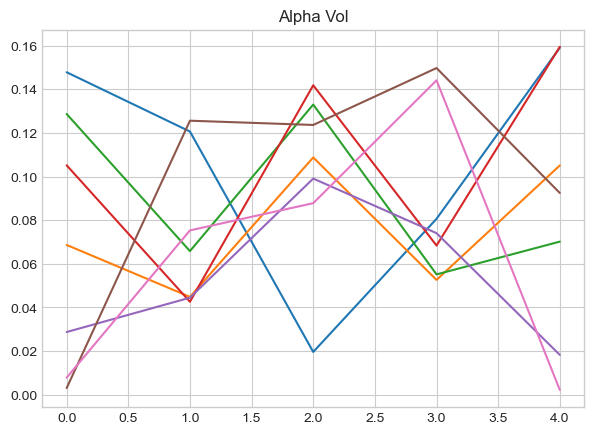

In [22]:
plt.plot([alpha1,alpha2, alpha3, alpha4,alpha5])
plt.title("Alpha Vol")

In [23]:
alphas = a[-1] # Usaremos este vector de alphas como el que optimiza
alphas

array([0.00784337, 0.07531106, 0.08777279, 0.14406302, 0.00220892])

#### Usemos estos valores para calcular el valor del cupón que valora a par

In [24]:
alphas = [0.00136473, 0.0051052, 0.00770603, 0.00757789, 0.0070979]

In [28]:
# Sabemos que para valorar a par, el valor final del bono debe ser 100, y esto a su vez debe equivaler a la suma de los bonos traidos a valor presente más el nocional que se paga en el último periodo también traido a valor presente
100 = helpers.discountfactor(alphas[2], 12)*helpers.rateconverter(c,12,today) + helpers.discountfactor(alphas[2], 24)*helpers.rateconverter(c,24,today) +
helpers.discountfactor(alphas[3], 36)*helpers.rateconverter(c,36,today) +helpers.discountfactor(alphas[3], 48)*helpers.rateconverter(c,48,today) +
helpers.discountfactor(alphas[4], 60)*helpers.rateconverter(c,60,today)+helpers.discountfactor(alphas[4], 72)*helpers.rateconverter(c,72,today) + 
helpers.discountfactor(alphas[4], 84)*helpers.rateconverter(c,84,today) + helpers.discountfactor(alphas[4], 84)*100

SyntaxError: cannot assign to literal (609821952.py, line 2)

In [25]:
# Traigamos a valor presente el pago del nocional
pvnotional = helpers.discountfactor(alphas[4], 84)*100

In [33]:
pvnotional

95.15288235085674

In [26]:
# Restando del valor original, obtenemos que la suma de los cupones traidos a valor presente es:
totalcoupons = 100-pvnotional
print(totalcoupons)

4.847117649143257


#### Iterando sobre algunos valores de C obtenemos que el valor de C que satisface la valoración a par del bono es:

In [27]:
c = 0.37

In [58]:
couponsum =\
  helpers.discountfactor(alphas[2], 12)*helpers.rateconverter(c,12,today) \
+ helpers.discountfactor(alphas[2], 24)*helpers.rateconverter(c,24,today)\
+ helpers.discountfactor(alphas[3], 36)*helpers.rateconverter(c,36,today)\
+ helpers.discountfactor(alphas[3], 48)*helpers.rateconverter(c,48,today)\
+ helpers.discountfactor(alphas[4], 60)*helpers.rateconverter(c,60,today)\
+ helpers.discountfactor(alphas[4], 72)*helpers.rateconverter(c,72,today)\
+ helpers.discountfactor(alphas[4], 84)*helpers.rateconverter(c,84,today)

couponsum

4.671265863175387

In [34]:
def couponerror(c):
    couponsum =\
  helpers.discountfactor(alphas[2], 12)*helpers.rateconverter(c,12,today) \
+ helpers.discountfactor(alphas[2], 24)*helpers.rateconverter(c,24,today)\
+ helpers.discountfactor(alphas[3], 36)*helpers.rateconverter(c,36,today)\
+ helpers.discountfactor(alphas[3], 48)*helpers.rateconverter(c,48,today)\
+ helpers.discountfactor(alphas[4], 60)*helpers.rateconverter(c,60,today)\
+ helpers.discountfactor(alphas[4], 72)*helpers.rateconverter(c,72,today)\
+ helpers.discountfactor(alphas[4], 84)*helpers.rateconverter(c,84,today)
    
    totalcoupons = 4.84711
    return couponsum - totalcoupons

In [37]:
coupon = minimize(couponerror,c)

/Users/rafael/Factored/Universidad/Riesgo/T1-Riesgo/scripts/helpers.py:35: RuntimeWarning: invalid value encountered in sqrt
  semrate = ((1+rate)**(1/2))-1
/Users/rafael/Factored/Universidad/Riesgo/T1-Riesgo/scripts/helpers.py:35: RuntimeWarning: invalid value encountered in sqrt
  semrate = ((1+rate)**(1/2))-1
/Users/rafael/Factored/Universidad/Riesgo/T1-Riesgo/scripts/helpers.py:35: RuntimeWarning: invalid value encountered in sqrt
  semrate = ((1+rate)**(1/2))-1


In [38]:
coupon

      fun: array([nan])
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 224
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([-1033.87])

#### Calibración de curvas del último año

In [243]:
def error2(alpha, df, day):
    firstyields = df[df.index == day]
    maturitydates = [3,6,12,24,36,60,84,120]
    bondvalues = [bondvalue(today, i, firstyields, alpha) for i in maturitydates]
    errorval= np.sum(np.abs(np.subtract(100,bondvalues)))
    return errorval

In [275]:
lastyear = df

In [ ]:
### No correr! Toma un buen tiempo
alphalevels = []
for i in lastyear.index:
    res = minimize(error2, alphas, args = (lastyear, i), bounds = ((0,.3),(0,.3),(0,.3),(0,.3),(0,.3)))
    alphalevels.append(res.x)

In [278]:
dfalpha = pd.DataFrame(alphalevels)

In [48]:
dfalpha.to_csv("alphaniveles.csv")

In [161]:
lastyear

NameError: name 'lastyear' is not defined

In [ ]:

alphalevels2 = []
for i in lastyear.index:
    res = minimize(error2, alphas, args = (lastyear, i), bounds = ((0,.3),(0,.3),(0,.3),(0,.3),(0,.3)))
    alphalevels.append(res.x)

####  Segunda parte

In [139]:
import sympy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpers as helpers
from scipy.optimize import minimize, show_options, basinhopping, differential_evolution, brute
from math import sqrt as msqrt

In [140]:
dfalpha = pd.read_csv("../data/alphaniveles.csv")

In [141]:
dfalpha

,Unnamed: 0,0,1,2,3,4
0,0,0.00000000000,0.03442301881,0.05072898445,0.03172771897,0.00000000000
1,1,0.00000000000,0.03322962224,0.05003963865,0.03145619829,0.00000000000
2,2,0.01959401328,0.02107562037,0.04375111075,0.02403385797,0.00000000000
3,3,0.00585733585,0.02291917042,0.03833434012,0.01211406715,0.00000000000
4,4,0.00958430115,0.02423163149,0.03059171532,0.00738332981,0.00000000000
...,...,...,...,...,...,...
205,205,0.05332877848,0.03092176767,0.08041909961,0.11056538963,0.19611240552
206,206,0.01907220600,0.03679880888,0.08045159325,0.10870484430,0.16234882443
207,207,0.04832108261,0.02529805610,0.08078085274,0.11167507652,0.15651809987
208,208,0.03079054466,0.03430044622,0.07944924243,0.10642038184,0.15783559394


In [142]:
alphadiff = dfalpha.diff()

In [143]:
alphadiff = alphadiff.drop(columns= "Unnamed: 0")

In [144]:
alphadiff = alphadiff.iloc[1:]

In [145]:
alphadiff

,0,1,2,3,4
1,0.00000000000,-0.00119339657,-0.00068934580,-0.00027152069,0.00000000000
2,0.01959401328,-0.01215400187,-0.00628852791,-0.00742234032,0.00000000000
3,-0.01373667743,0.00184355005,-0.00541677063,-0.01191979082,0.00000000000
4,0.00372696530,0.00131246107,-0.00774262480,-0.00473073734,0.00000000000
5,0.00304296345,-0.00102097215,-0.00151737370,-0.00638264177,0.00000000000
...,...,...,...,...,...
205,0.05332877848,-0.01295736107,-0.00004730868,0.00289900618,0.01559467580
206,-0.03425657248,0.00587704121,0.00003249365,-0.00186054533,-0.03376358109
207,0.02924887662,-0.01150075278,0.00032925948,0.00297023222,-0.00583072457
208,-0.01753053795,0.00900239012,-0.00133161031,-0.00525469468,0.00131749408


In [146]:
columnnames = {'0': 'alpha1', '1': 'alpha2', '2': 'alpha3', '3': 'alpha4', '4': 'alpha5'}

In [147]:
alphadiff.rename(columns = columnnames, inplace=True)

In [148]:
varcov = alphadiff.cov()

In [149]:
pd.set_option('display.float_format', lambda x: '%.11f' % x)

In [150]:
varcov

,alpha1,alpha2,alpha3,alpha4,alpha5
alpha1,0.00022805626,-0.00008126533,0.00000239949,0.00000915210,-0.00001522078
alpha2,-0.00008126533,0.00009998439,-0.00002623875,-0.00000773631,-0.00000043530
alpha3,0.00000239949,-0.00002623875,0.00002351571,0.00000839250,0.00001874815
alpha4,0.00000915210,-0.00000773631,0.00000839250,0.00002804817,0.00002560018
alpha5,-0.00001522078,-0.00000043530,0.00001874815,0.00002560018,0.00017889639


In [151]:
varcov2 = sympy.Matrix(varcov.values)

In [152]:
calceigenvalues = varcov2.eigenvals() 

In [153]:
eigenvalues = []
for i in calceigenvalues:
    eigenvalues.append(i)

In [154]:
eigenvalues.sort(reverse= True)

In [155]:
eigenvalues

[0.000270267460406596,
 0.000185345994198844,
 6.92479966323723e-5,
 2.36578158831054e-5,
 9.98165974576045e-6]

In [156]:
eigenvectors = []
for i in range(4,-1,-1):
    calc = (varcov2.eigenvects()[i][2][0]) #Eigenvectors are organized from lowest to greatest associated eigenvalue
    d= []
    for j in range(0,5):
        d.append(calc[j])
    eigenvectors.append(d)

In [157]:
A = pd.DataFrame(eigenvectors).transpose()

In [158]:
A

,0,1,2,3,4
0,0.0626260315277638,0.890352827414663,-0.431775882829697,0.0117478704908033,-0.129543033140980
1,-0.123919186434048,-0.433344255915067,-0.800838586887104,0.175550527864868,-0.353123719138169
2,0.141795409486756,0.0463220617475552,0.387831086015843,0.197833269196064,-0.887804806679322
3,0.174274616382160,0.0356910899060476,0.0463224307663882,0.947647292372982,0.261100260153488
4,0.964491801593949,-0.126747825531270,-0.140244165251059,-0.178523406203925,0.0463844902045418


In [159]:
sqeigenvalues = [msqrt(i) for i in eigenvalues]

In [160]:
B = A.mul(sqeigenvalues)
B

,0,1,2,3,4
0,0.00102956026426067,0.0121214268319146,-0.00359303946696056,5.71408207285932e-5,-0.000409275212122835
1,-0.00203720828575007,-0.00589962824777845,-0.00666420882633046,0.000853865494124159,-0.00111565077296433
2,0.00233109005473888,0.000630637051838011,0.00322735116523109,0.000962247190087202,-0.00280490962552896
3,0.00286504215131049,0.000485905049690997,0.000385473873293725,0.00460929017644617,0.000824914020990613
4,0.0158560651202382,-0.00172556816351417,-0.00116704716682091,-0.000868325366520008,0.000146546067413856


Text(0.5, 1.0, 'Components')

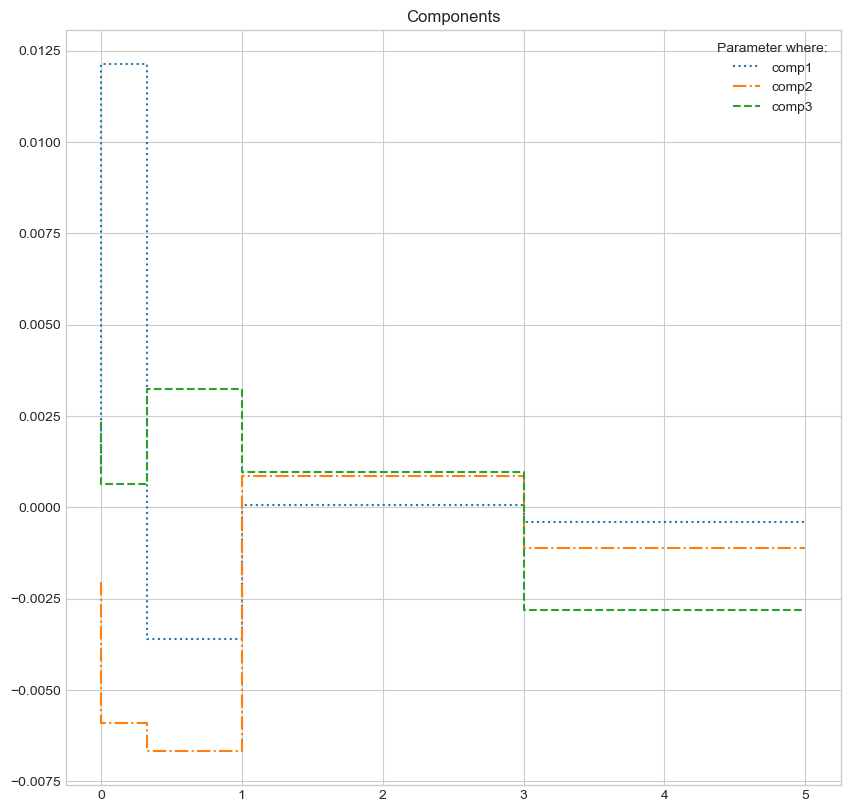

In [132]:
plt.step(y = B.loc[0,:], x = [0,0.33,1,3,5], label = "comp1", linestyle = ":")
plt.step(y = B.loc[1,:], x = [0,0.33,1,3,5], label = "comp2", linestyle = "-.")
plt.step(y = B.loc[2,:], x = [0,0.33,1,3,5], label = "comp3", linestyle = "--")
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize':(8,8), 'figure.dpi':100})
plt.legend(title='Parameter where:')
plt.title('Components')

In [108]:
len(B.loc[0,:])

5

In [85]:
X=alphadiff

In [86]:
X

,alpha1,alpha2,alpha3,alpha4,alpha5
1,0.00000000000,-0.00119339657,-0.00068934580,-0.00027152069,0.00000000000
2,0.01959401328,-0.01215400187,-0.00628852791,-0.00742234032,0.00000000000
3,-0.01373667743,0.00184355005,-0.00541677063,-0.01191979082,0.00000000000
4,0.00372696530,0.00131246107,-0.00774262480,-0.00473073734,0.00000000000
5,0.00304296345,-0.00102097215,-0.00151737370,-0.00638264177,0.00000000000
...,...,...,...,...,...
205,0.05332877848,-0.01295736107,-0.00004730868,0.00289900618,0.01559467580
206,-0.03425657248,0.00587704121,0.00003249365,-0.00186054533,-0.03376358109
207,0.02924887662,-0.01150075278,0.00032925948,0.00297023222,-0.00583072457
208,-0.01753053795,0.00900239012,-0.00133161031,-0.00525469468,0.00131749408
